<a href="https://colab.research.google.com/github/AhsanFarooq00/Innovative_Deep_Learning_Models_for_Brain_Tumor_Diagnosis-/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the Libraries

In [ ]:
# For Data Processing
import numpy as np  # Core library for numerical computations with support for arrays and matrices
import pandas as pd  # Powerful data manipulation and analysis library, useful for handling data in tabular form (DataFrames)
from sklearn.utils import shuffle  # Utility to shuffle the dataset, ensuring randomization
from sklearn.model_selection import train_test_split  # Function to split dataset into training and testing sets
from sklearn.metrics import roc_curve, auc  # Functions for computing Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC)
from sklearn.preprocessing import label_binarize  # Utility to convert class labels to a binary matrix form for multi-class classification
from sklearn.metrics import confusion_matrix, classification_report  # Tools for evaluating model performance through confusion matrix and detailed classification report
from tqdm import tqdm  # Library to create progress bars for loops, useful for tracking the progress of tasks
import os  # Module to interact with the operating system, useful for file and directory operations
import random  # Provides functions for generating random numbers, useful for data augmentation and splitting
from PIL import Image, ImageEnhance, ImageOps  # Python Imaging Library for opening, manipulating, and saving images
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator  # Functions for image loading and real-time data augmentation
from tensorflow.keras.layers import BatchNormalization  # Layer that normalizes activations, stabilizing and speeding up training

# For Data Visualization
import matplotlib.pyplot as plt  # Library for creating static, animated, and interactive visualizations in Python
import seaborn as sns  # Data visualization library based on Matplotlib, provides a high-level interface for drawing attractive statistical graphics
from itertools import cycle  # Utility to cycle through elements, commonly used for color cycling or repetitive tasks

# For Machine Learning and Deep Learning
import tensorflow as tf  # Open-source platform for machine learning and deep learning models
from tensorflow.keras.regularizers import l2  # Regularization technique to prevent overfitting by penalizing large weights

from tensorflow.keras.models import Sequential  # Sequential model type for stacking layers linearly in Keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Callbacks for early stopping, saving best model checkpoints, and reducing learning rate when a metric plateaus
from tensorflow.keras.layers import BatchNormalization  # Batch normalization layer to stabilize and accelerate training by normalizing the input of each layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Commonly used layers in Convolutional Neural Networks (CNNs) for image classification
from tensorflow.keras.optimizers import Adam, Adamax  # Optimization algorithms used for minimizing the loss function and updating model weights


# Loading the Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/MRI Brain Tumor Dataset/Training/'
test_dir = '/content/drive/MyDrive/MRI Brain Tumor Dataset/Testing/'

train_paths = []
train_labels = []

# Iterate over each label (subdirectory) in the training directory
for label in os.listdir(train_dir):
  # Iterate over each image file in the label subdirectory
    for image in os.listdir(train_dir+label):
      # Append the full image path to the train_paths list
        train_paths.append(train_dir+label+'/'+image)
        # Append the label to the train_labels list
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
# Convert to DataFrame
train_df = pd.DataFrame({
    'Image Path': train_paths,
    'Class Label': train_labels
})

# Distribution Of Image Data

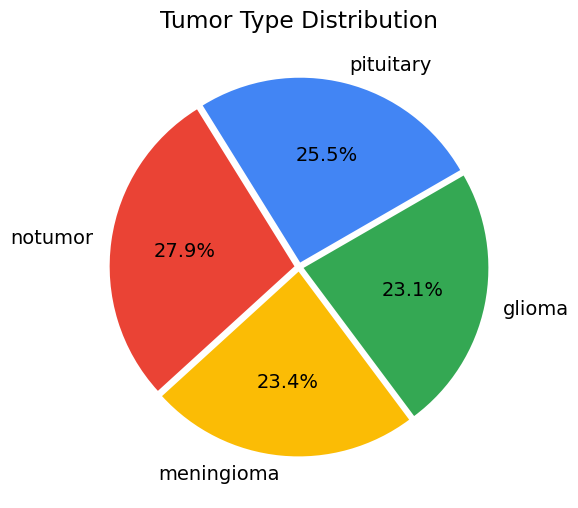

In [ ]:
def plot_tumor_distribution(train_labels):
    plt.figure(figsize=(8, 6))
    colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
    plt.rcParams.update({'font.size': 14})

    labels = ['pituitary', 'notumor', 'meningioma', 'glioma']
    sizes = [len([x for x in train_labels if x == label]) for label in labels]

    plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%',
            explode=(0.025, 0.025, 0.025, 0.025), startangle=30)

    plt.title('Tumor Type Distribution')
    plt.show()

plot_tumor_distribution(train_labels)

In [ ]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
# Convert to DataFrame
test_df = pd.DataFrame({
    'Image Path': test_paths,
    'Class Label': test_labels
})

**Distribution of Data in training and testing**

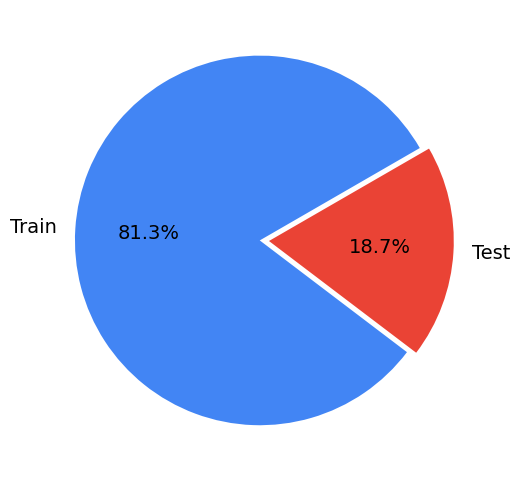

In [ ]:
plt.figure(figsize=(8,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# Spliting the Data

In [ ]:
valid_df, ts_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class Label'])

In [ ]:
# Parameters
batch_size = 32
img_size = (128, 128)
brightness_range = (0.8, 1.2)
rescale_factor = 1/255
num_classes = 4  # Example number of classes
epochs = 10   # Number of epochs in training

# Data Augmentation

In [ ]:
# Define data augmentation parameters for training
train_data_gen_args = dict(
    rescale=rescale_factor,
    brightness_range=brightness_range,
)

In [ ]:
# Define data augmentation parameters for validation and testing (usually less augmentation)
valid_test_data_gen_args = dict(rescale=rescale_factor)

# Create ImageDataGenerators with parameters
train_val_gen = ImageDataGenerator(**train_data_gen_args)
valid_test_gen = ImageDataGenerator(**valid_test_data_gen_args)


In [ ]:
# Function to create generators from dataframes
def create_generators(tr_df, valid_df, ts_df, batch_size, img_size):
    if tr_df.empty or valid_df.empty or ts_df.empty:
        raise ValueError("One of the dataframes is empty. Please check your dataframes.")

    train_gen = train_val_gen.flow_from_dataframe(
        tr_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'  # Assuming you have categorical labels
    )

    valid_gen = valid_test_gen.flow_from_dataframe(
        valid_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=batch_size,
        target_size=img_size,
        class_mode='categorical'
    )

    test_gen_flow = valid_test_gen.flow_from_dataframe(
        ts_df,
        x_col='Image Path',
        y_col='Class Label',
        batch_size=16,
        target_size=img_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, valid_gen, test_gen_flow

# Create generators
train_gen, valid_gen, test_gen_flow = create_generators(train_df, valid_df, ts_df, batch_size, img_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


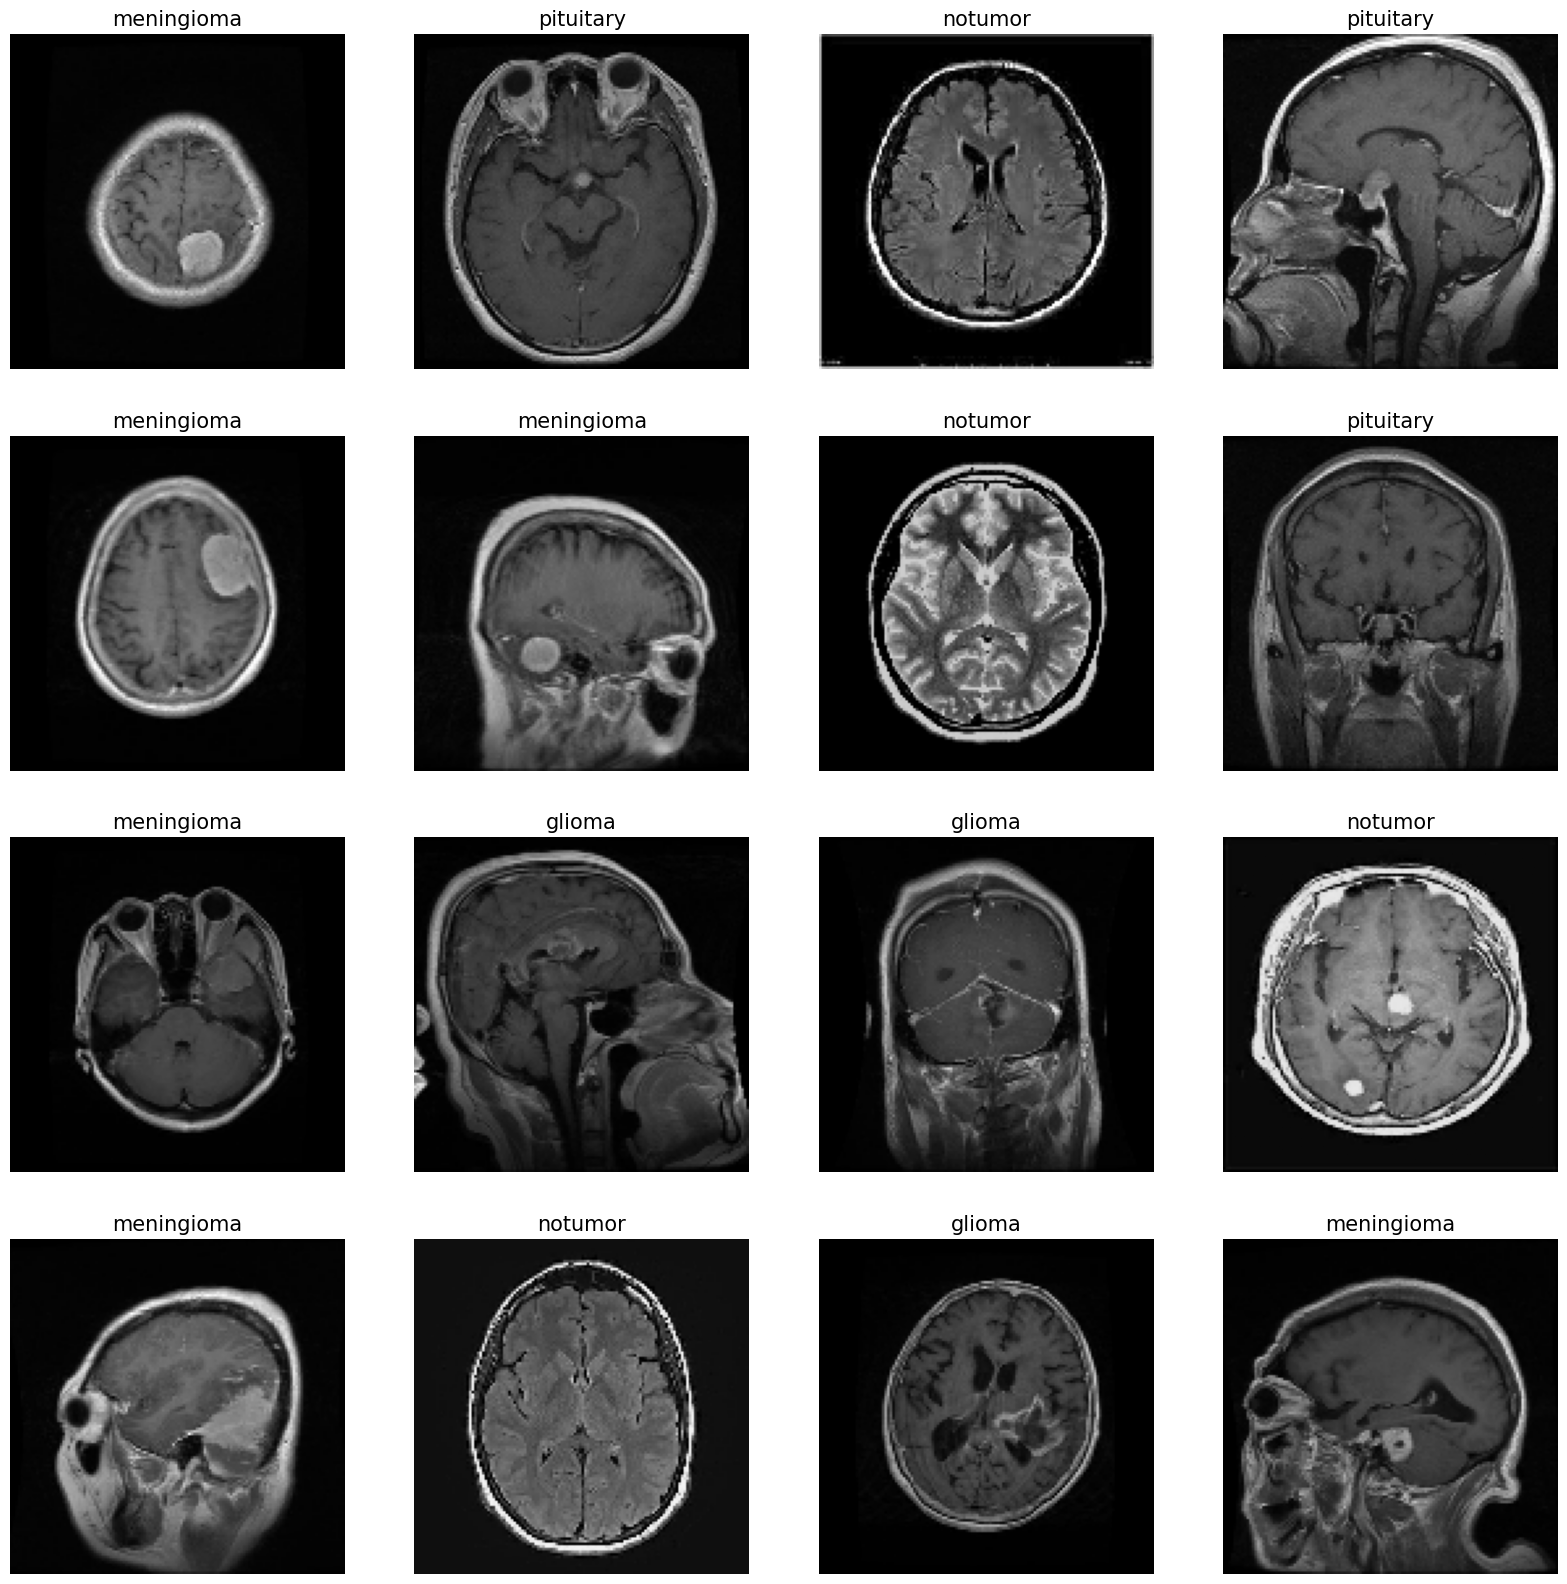

In [ ]:
# Visualize some augmented images from the training generator
images, labels = next(train_gen)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(20, 20))
for i in range(min(len(images), 16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    class_name = class_names[np.argmax(labels[i])]
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')
plt.show()


# CNN Model Design

In [ ]:
# Model Architecture
model = Sequential()

# Convolutional layers with L2 regularization and Batch Normalization
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3), kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.002)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Fully connected layers with increased dropout and L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.5))  # Increased dropout rate

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.002)))
model.add(Dropout(0.5))  # Increased dropout rate

# Output layer
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model with a reduced learning rate
model.compile(optimizer=Adamax(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │              

 Total params: 9,688,196 (36.96 MB)

 Trainable params: 9,686,340 (36.95 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Training the model with data augmentation
history = model.fit(train_gen,
                    epochs=50,
                    validation_data=valid_gen,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 1620s 9s/step - accuracy: 0.5495 - loss: 5.4113 - val_accuracy: 0.2855 - val_loss: 5.4554 - learning_rate: 1.0000e-04
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - accuracy: 0.7329 - loss: 4.5002 - val_accuracy: 0.3634 - val_loss: 5.3265 - learning_rate: 1.0000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step - accuracy: 0.7817 - loss: 4.3717 - val_accuracy: 0.6550 - val_loss: 4.6018 - learning_rate: 1.0000e-04
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.8046 - loss: 4.2748 - val_accuracy: 0.7878 - val_loss: 4.2691 - learning_rate: 1.0000e-04
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.8270 - loss: 4.2028 - val_accuracy: 0.8366 - val_loss: 4.1337 - learning_rate: 1.0000e-04
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.8468 - loss: 4.1112 - val_accuracy: 0.8458 - val_loss: 4.0899 - learning_rate: 1.0000e-04
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 164ms/step - a

## Traning Curves

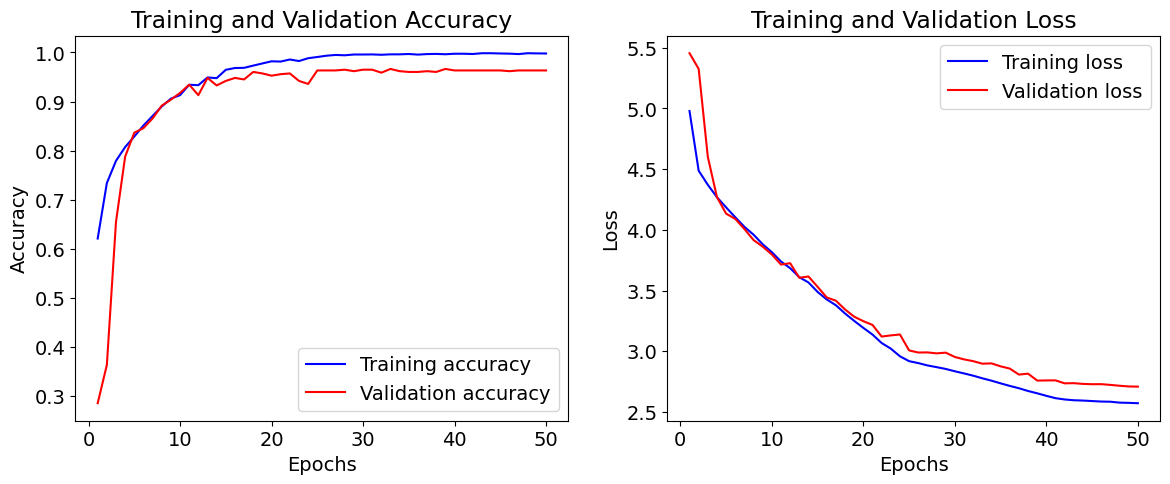

In [ ]:
def plot_training_history(history):
    # Extract values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Usage
plot_training_history(history)

# Model Evaluation

In [ ]:
# Evaluate the model on the test dataset
final_test_loss, final_test_accuracy = model.evaluate(test_gen_flow, verbose=1)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predict on the test dataset
final_test_predictions = model.predict(test_gen_flow)
predicted_classes = np.argmax(final_test_predictions, axis=1)
true_classes = test_gen_flow.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.9651 - loss: 2.6987
Final Test Loss: 2.6932573318481445
Final Test Accuracy: 0.9649389982223511
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


# Confusion Matrix

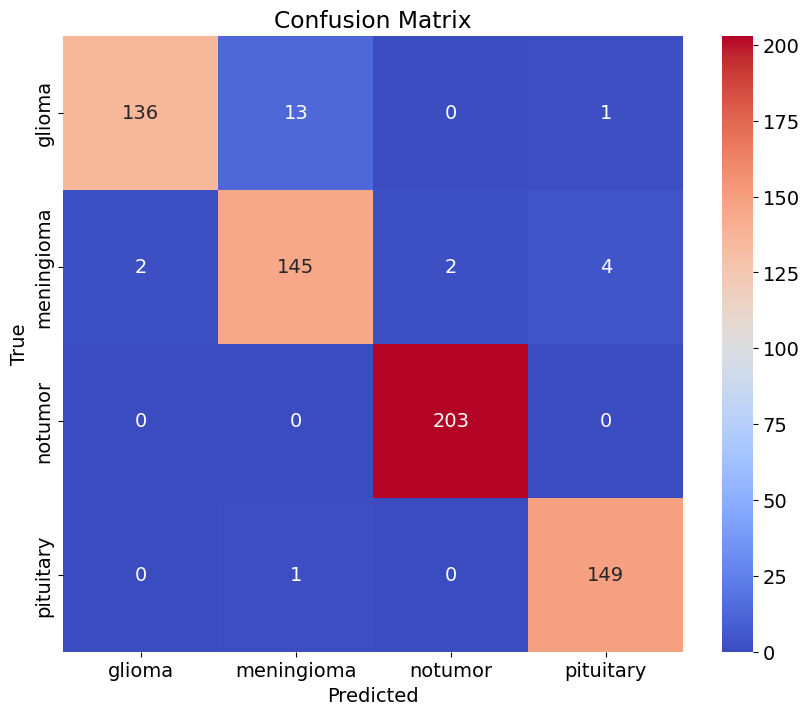

              precision    recall  f1-score   support

      glioma       0.99      0.91      0.94       150
  meningioma       0.91      0.95      0.93       153
     notumor       0.99      1.00      1.00       203
   pituitary       0.97      0.99      0.98       150

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.97      0.96      0.96       656



In [ ]:
def plot_confusion_matrix(true_classes, pred_classes, class_names):
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names
class_names = list(test_gen_flow.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, class_names)

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# ROC Curves

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


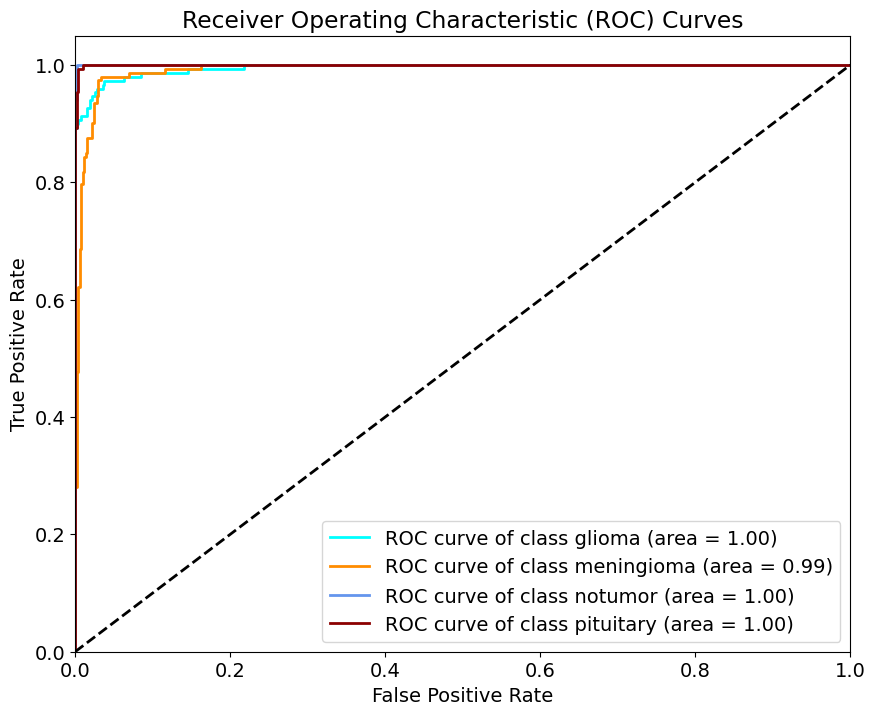

In [ ]:
# Function to plot ROC curves for multi-class classification
def plot_roc_curves(true_classes, pred_probabilities, class_names):
    # Binarize the true classes
    true_classes_binarized = label_binarize(true_classes, classes=range(len(class_names)))
    n_classes = len(class_names)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], pred_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'green', 'purple', 'brown'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.show()

# Get class names
class_names = list(test_gen_flow.class_indices.keys())

# Predict probabilities for the ROC curve
predicted_probabilities = model.predict(test_gen_flow)

# Plot ROC curves
plot_roc_curves(true_classes, predicted_probabilities, class_names)

# Saving the CNN Model

In [ ]:
# Save the entire model to a file
model.save('/content/drive/MyDrive/CNN_model.h5')

# Transfer Learning

In [ ]:
img_shape=(128,128,3)
base_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Defining Model

In [ ]:
Model_tr = Sequential([
    base_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

# Compiling the Model

In [ ]:
Model_tr.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])


# Training the Model

In [ ]:
historyy=Model_tr.fit(train_gen,epochs=10,
                  validation_data=valid_gen,
                  shuffle=False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 340ms/step - accuracy: 0.7437 - loss: 0.6678 - val_accuracy: 0.7527 - val_loss: 0.7202
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.9489 - loss: 0.1424 - val_accuracy: 0.9374 - val_loss: 0.1770
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 49s 272ms/step - accuracy: 0.9835 - loss: 0.0574 - val_accuracy: 0.9573 - val_loss: 0.1425
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.9927 - loss: 0.0247 - val_accuracy: 0.9771 - val_loss: 0.0612
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 47s 261ms/step - accuracy: 0.9938 - loss: 0.0252 - val_accuracy: 0.9771 - val_loss: 0.0562
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 237ms/step - accuracy: 0.9950 - loss: 0.0161 - val_accuracy: 0.9878 - val_loss: 0.0367
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - accuracy: 0.9922 - loss: 0.0250 - val_accuracy: 0.9908 - val_loss: 0.0521
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.9966 - loss: 

# Ploting the Curves

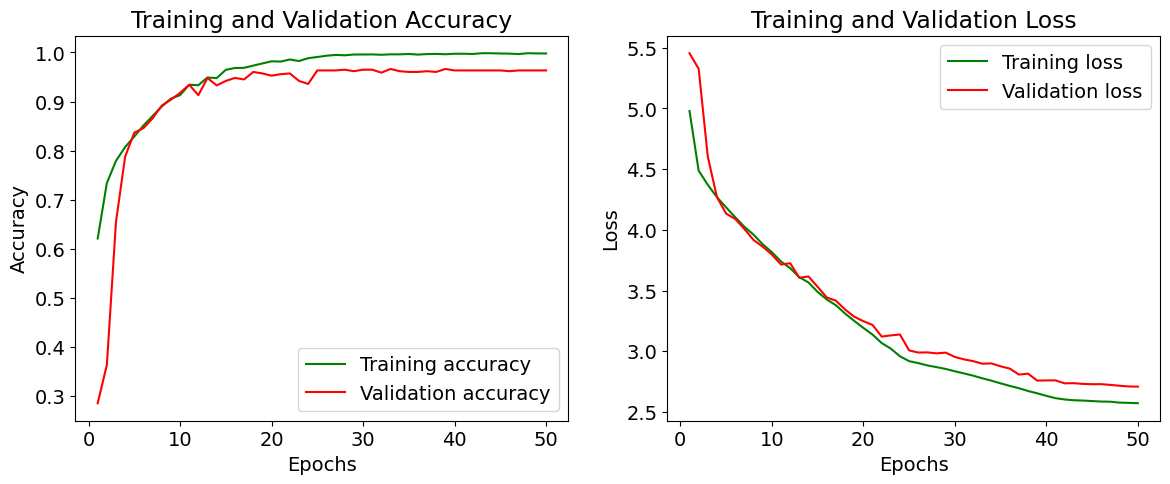

In [ ]:
def plot_training_history(history):
    # Extract values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Usage
plot_training_history(history)

# Model Evaluation

In [ ]:
# Evaluate the model on the test dataset
final_test_loss, final_test_accuracy = Model_tr.evaluate(test_gen_flow, verbose=1)
print(f'Final Test Loss: {final_test_loss}')
print(f'Final Test Accuracy: {final_test_accuracy}')

# Predict on the test dataset
final_test_predictions = Model_tr.predict(test_gen_flow)
predicted_classes = np.argmax(final_test_predictions, axis=1)
true_classes = test_gen_flow.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.9894 - loss: 0.0434
Final Test Loss: 0.05234404280781746
Final Test Accuracy: 0.9862805008888245
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step


# Confusion Matrix

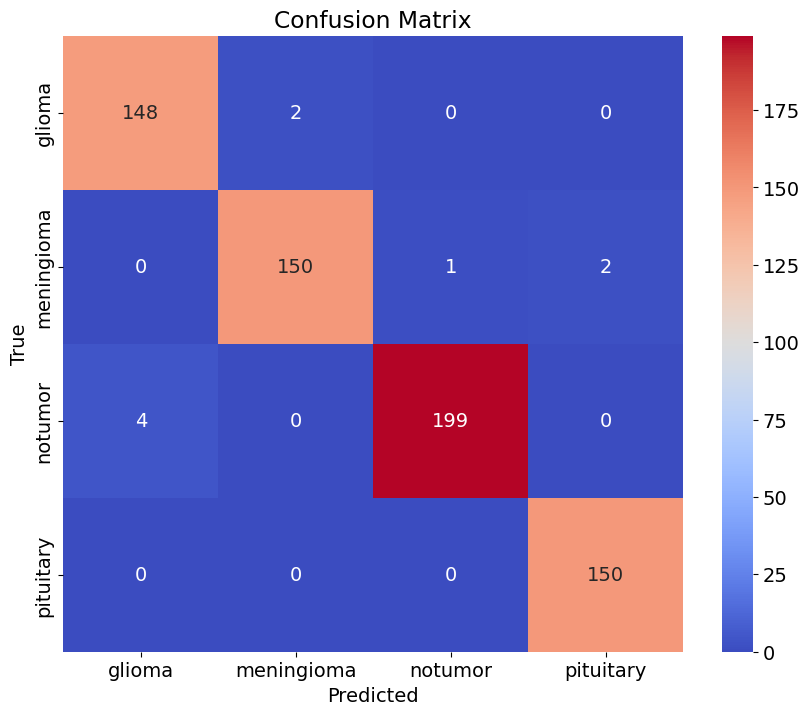

              precision    recall  f1-score   support

      glioma       0.97      0.99      0.98       150
  meningioma       0.99      0.98      0.98       153
     notumor       0.99      0.98      0.99       203
   pituitary       0.99      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [ ]:
def plot_confusion_matrix(true_classes, pred_classes, class_names):
    cm = confusion_matrix(true_classes, pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get class names
class_names = list(test_gen_flow.class_indices.keys())

# Plot confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, class_names)

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Roc Curves

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step


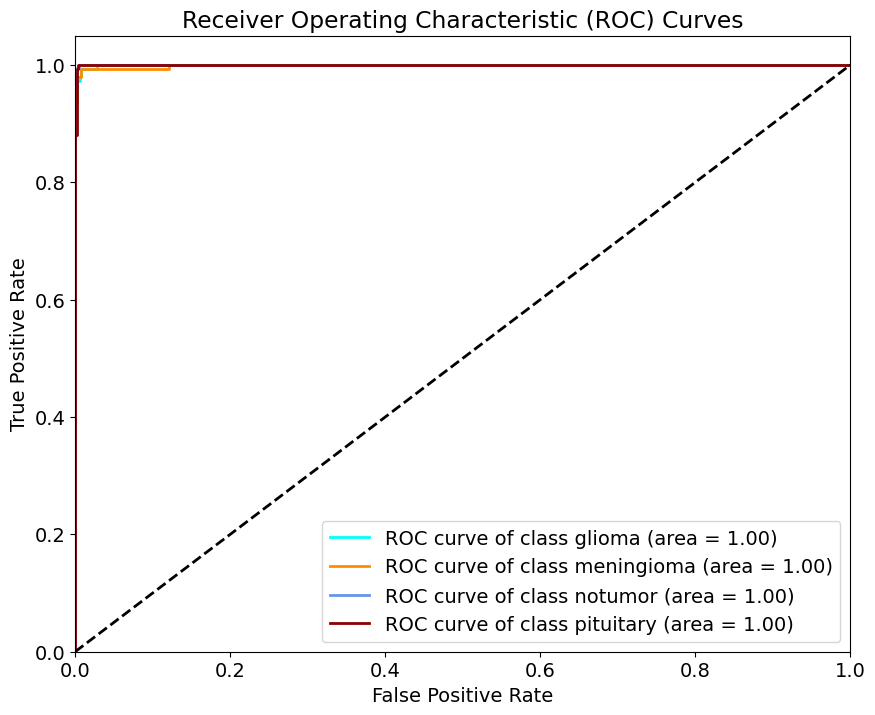

In [ ]:
# Function to plot ROC curves for multi-class classification
def plot_roc_curves(true_classes, pred_probabilities, class_names):
    # Binarize the true classes
    true_classes_binarized = label_binarize(true_classes, classes=range(len(class_names)))
    n_classes = len(class_names)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_classes_binarized[:, i], pred_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'green', 'purple', 'brown'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.show()

# Get class names
class_names = list(test_gen_flow.class_indices.keys())

# Predict probabilities for the ROC curve
predicted_probabilities = Model_tr.predict(test_gen_flow)

# Plot ROC curves
plot_roc_curves(true_classes, predicted_probabilities, class_names)

# Saving the Transfer Learning Model

In [ ]:
# Save the entire model to a file
Model_tr.save('/content/drive/MyDrive/tr_model.h5')